# Lab 1, Problem 2 - Machine Learning for Industry
Linköping University, Fall 2019.\
Author: Mattias Villani, Linköping and Stockholm University, http://mattiasvillani.com

The task here is to analyze the bike sharing data from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset.
Our task is to build a prediction model for the daily number of rides taken with the company's shared bikes.
We will use the daily data.

Let us import some modules

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm # statsmodels contains more detailed regression routines
import seaborn as sns;sns.set_context('talk')
import matplotlib.pylab as plt
np.random.seed(seed=123) # Set the seed for reproducibility

Let's read the data from the course repository, and rename some variables so we understand what they measure.

In [2]:
# Loading the bike share data and renaming some variables
bikeData = pd.read_csv("https://github.com/STIMALiU/ml4industry/raw/master/Labs/bikesday.csv")    
bikeData = bikeData.rename(columns={"cnt": "nRides", "casual":"nCasualRides", "registered":"nRegRides", "atemp": "feelTemp"})
print(bikeData.shape)
bikeData.head(10)

(731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,feelTemp,hum,windspeed,nCasualRides,nRegRides,nRides
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321


Always good to explore the data by plotting it. Let's plot nRides against feelTemp.

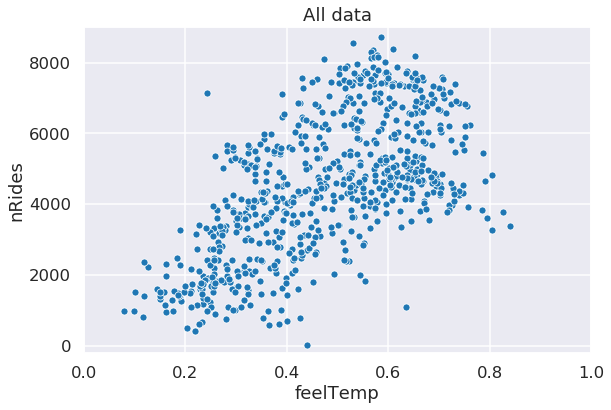

In [3]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
snsPlot = sns.scatterplot(x = "feelTemp", y = "nRides", data = bikeData, s = 50)
plt.title('All data')
snsPlot.set(xlim=(0,1), ylim = (-200,9000));

Note that the data looks rather unpredictable with a large variance. However, some of that variation will be explained by factors that we don't see in the plots above. 
If we for example also take into account the weather (weathersit=0 is clear, weathersit=3 is heavy rain) we can see that the variation is reduced:

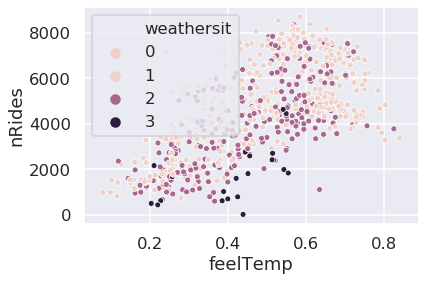

In [4]:
snsPlot = sns.scatterplot(x = "feelTemp", y = "nRides", hue = "weathersit", data = bikeData, s = 35)

## One-hot encoding of categorical variables

We want to fit supervised regression models to the training data. Here we need to be careful since many of the predictor variables are categorical. We will therefore encode them using one-hot encoding (dummy variables). A categorical variable with K categories (man/woman would for example be K=2) can be encoded into K new one-hot variables. It is customary to drop one of these variables, since they are linearly dependent. This is strictly not necessary when using regularization, and there is not agreed right way of doing this. I will drop one of the variables here, but feel free to experiment with using all of them when you have a regularized model.
We will use the categorical variables: 'season' (K=4), 'weekday' (K=7) and 'weathersit' (K=3). Here is how to transform them to one-hot variables:

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories = 'auto', sparse = False, drop = 'first') # Set up the one-hot encoder object
OneHot = enc.fit_transform(bikeData[['season','weekday','weathersit']]) # Make the transformation
featureNames = enc.get_feature_names(['season','weekday','weathersit']) # Get the names of the new one-hot features
OneHotFeatures = pd.DataFrame(OneHot, columns=featureNames) # Make it into a nice pandas dataframe where columns are named.

A careful person always checks if things seems right. Let's print out the original data and the one-hot variables to see if they make sense.

In [6]:
print('Original data')
print(bikeData[0:5][['season','weekday']])
print('One-hot features')
print(OneHotFeatures[0:5])

Original data
   season  weekday
0       1        6
1       1        0
2       1        1
3       1        2
4       1        3
One-hot features
   season_2  season_3  season_4  weekday_1  weekday_2  weekday_3  weekday_4  \
0       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
1       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
2       0.0       0.0       0.0        1.0        0.0        0.0        0.0   
3       0.0       0.0       0.0        0.0        1.0        0.0        0.0   
4       0.0       0.0       0.0        0.0        0.0        1.0        0.0   

   weekday_5  weekday_6  weathersit_2  weathersit_3  
0        0.0        1.0           1.0           0.0  
1        0.0        0.0           1.0           0.0  
2        0.0        0.0           0.0           0.0  
3        0.0        0.0           0.0           0.0  
4        0.0        0.0           0.0           0.0  


Seems right. Since we used drop='first', the first three columns of OneHotTrain record season 2, 3 and 4. The elements in first row are therefore
zero in the first three columns since the first observation is from season = 1 (the feature that we dropped to avoid linear dependence between features).\
The six last columns are for weekdays 1-6 (the first weekday is recorded as 0 and is dropped since drop='first'). First day is a sunday (6) and only
the last column is therefore 1.\
weathersit seems also ok.

We will redefine the data to contain the one-hot features (and keep the original data in bikeDataOrig):

In [7]:
bikeDataOrig = bikeData 
bikeData = pd.concat([bikeDataOrig[['nRides','feelTemp','hum','windspeed']], OneHotFeatures], axis = 1)
bikeData.head()

,nRides,feelTemp,hum,windspeed,season_2,season_3,season_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,985,0.363625,0.805833,0.160446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,801,0.353739,0.696087,0.248539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1349,0.189405,0.437273,0.248309,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1562,0.212122,0.590435,0.160296,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1600,0.229270,0.436957,0.186900,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Split data into training and testing

Let's split the data into training and test. I will here use the first 500 observations for training. The remaining 231 observations are used for testing. Note: since data is observed over time, I am using the last part for testing, since this is the generalizing performance we are interested in. Predicting the future.

In [8]:
# Dividing data into train and validation datasets
from sklearn.model_selection import train_test_split
bikeTrain, bikeTest = train_test_split(bikeData, train_size = 500, shuffle = False) # First 500 data points for training
print('Number of obs for training:',bikeTrain.shape[0])
print('Number of obs for testing:',bikeTest.shape[0])

Number of obs for training: 500
Number of obs for testing: 231


Let's plot the data to see if there is a big difference between training and testing data. 

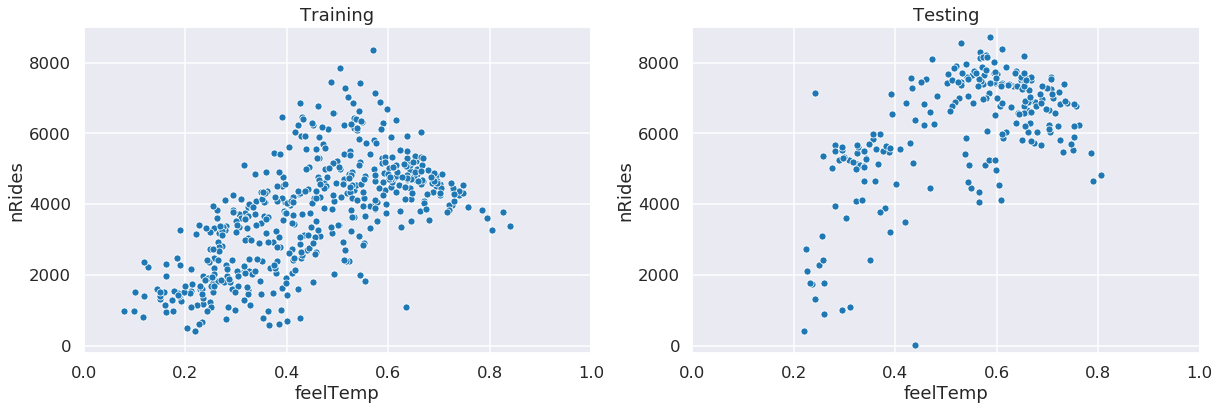

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
snsPlot = sns.scatterplot(x = "feelTemp", y = "nRides", data = bikeTrain, s = 50)
plt.title('Training')
snsPlot.set(xlim=(0,1), ylim = (-200,9000));

plt.subplot(1,2,2)
snsPlot = sns.scatterplot(x = "feelTemp", y = "nRides", data = bikeTest, s = 50)
plt.title('Testing')
snsPlot.set(xlim=(0,1), ylim = (-200,9000));

Seems like the testing data has somewhat similar properties, but perhaps a more quadratic relationship than in the training data. We should keep
in mind that this is actually time series data over differing seasons, so this is not too unexpected.

## Linear regression

In [10]:
# Fitting the linear model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
regModel = linear_model.LinearRegression()
regModel.fit(X = bikeTrain.drop('nRides',axis = 1), y = bikeTrain['nRides']); # We use all variables except nRides as predictors

# Evaluate prediction on test data
from sklearn.metrics import mean_squared_error 
yPredTest = regModel.predict(X = bikeTest.drop('nRides',axis = 1))
RMSE = np.sqrt(mean_squared_error(bikeTest['nRides'], yPredTest))
print('RMSE = ', RMSE)

RMSE =  2225.0434704393683


## Over to you now. 

Fit a **LassoLars** model and predict the test set. Estimate $\alpha$ using 5-fold cross-validation.

In [ ]:
# YOUR CODE HERE

Find out which predictor are important in the Lasso-model.

In [ ]:
# YOUR CODE HERE

Fit a **Decision trees** model  using the default settings and max_depth = 4. Predict the test set.

In [ ]:
# YOUR CODE HERE

Fit a **Random Forest** model using the default settings and max_depth = 4. Predict the test set.

In [ ]:
# YOUR CODE HERE

Finally, use **XGBoost** with the default settings and max_depth = 4.

In [ ]:
# YOUR CODE HERE

Make of a plot of the importance of the different features in this XGBoost fit.

In [ ]:
# YOUR CODE HERE

To avoid overfitting, XGBoost can be trained such that it more slowly updates its learned weights in its gradient boosted algorithm. The argument <tt>learning_rate</tt> ($ \eta \in [0,1]$) control this. Use 5-fold cross-validation to determine the value for <tt>learning_rate</tt> that minimizes cross-validated RMSE. Note that unlike, Lasso, there is not ready-made function for this, you have to loop over the cross-validation folds yourself.\
**Hint**: from sklearn.model_selection import cross_validate

In [ ]:
# YOUR CODE HERE

# Time series modeling

So far we have considered this as a regression problem. However, the data is recorded over time, so it is a time series. 
This will probably be too much for you to do in a single lab, but let me illustrate how we could add time series effect to the model.
From this point on, there is no more work for you to do, except reading through what I have done.

Let's plot the varible nRides in the training and test data over time.

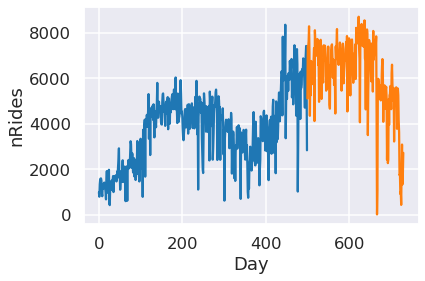

In [11]:
plt.plot(bikeTrain['nRides'])
plt.plot(bikeTest['nRides'])
plt.xlabel('Day');
plt.ylabel('nRides');

Note that something strange is happening between day 600 and 700. At least one day seems incredibly low nRides, almost zero. Let's find out what happend:

In [12]:
bikeData['nRides'].min() # min value
obsMin = bikeData['nRides'].idxmin() # find out which observation contains minimum
bikeData[obsMin-5:obsMin+5] # Have a look around the strange observation:

,nRides,feelTemp,hum,windspeed,season_2,season_3,season_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
662,7693,0.558721,0.636250,0.072779,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
663,7359,0.529688,0.800417,0.124375,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
664,7444,0.522750,0.807083,0.132467,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
665,7852,0.515133,0.720000,0.235692,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
666,4459,0.467771,0.694583,0.398008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
667,22,0.439400,0.880000,0.358200,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
668,1096,0.309909,0.825455,0.213009,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
669,5566,0.361100,0.666667,0.166667,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
670,5986,0.369942,0.581667,0.157346,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
671,5847,0.356042,0.522083,0.266175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Wow, nRides = 22 on that day. The day before (obs 666) was also somewhat low, and the day after (obs 668). And the series did not seem to recover after this
event (was close to 8000 before and only less than 6000 after). Let's go back to the original data to get the date for the event:

In [13]:
bikeDataOrig[obsMin-5:obsMin+5]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,feelTemp,hum,windspeed,nCasualRides,nRegRides,nRides
662,663,2012-10-24,4,1,10,0,3,1,1,0.587500,0.558721,0.636250,0.072779,795,6898,7693
663,664,2012-10-25,4,1,10,0,4,1,2,0.550000,0.529688,0.800417,0.124375,875,6484,7359
664,665,2012-10-26,4,1,10,0,5,1,2,0.545833,0.522750,0.807083,0.132467,1182,6262,7444
665,666,2012-10-27,4,1,10,0,6,0,2,0.530000,0.515133,0.720000,0.235692,2643,5209,7852
666,667,2012-10-28,4,1,10,0,0,0,2,0.477500,0.467771,0.694583,0.398008,998,3461,4459
667,668,2012-10-29,4,1,10,0,1,1,3,0.440000,0.439400,0.880000,0.358200,2,20,22
668,669,2012-10-30,4,1,10,0,2,1,2,0.318182,0.309909,0.825455,0.213009,87,1009,1096
669,670,2012-10-31,4,1,10,0,3,1,2,0.357500,0.361100,0.666667,0.166667,419,5147,5566
670,671,2012-11-01,4,1,11,0,4,1,2,0.365833,0.369942,0.581667,0.157346,466,5520,5986
671,672,2012-11-02,4,1,11,0,5,1,1,0.355000,0.356042,0.522083,0.266175,618,5229,5847


So, what happened on 2012-10-29? From https://www.onthisday.com/date/2012/october/29 we learn that: 'Hurricane Sandy makes landfall in New Jersey resulting in 110 deaths'. This hurricane was predicted and this is the reason for the smaller number of rides on October 28.\
We will set nRides on 2012-10-29 and 2012-10-30 to 4000, just a quick-and-dirty fix.

In [14]:
bikeData['nRides'][667:669] = [4000,4000]

/home/mv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Time series modeling is a very rich field with its own set of methods. An easy way to include time series effects in our regression model is to add
lagged values of the response (nRides) as additional features. A lag is just the time series (here nRides) shifted one time period. This way we model
nRides today as function of nRides yesterday, which may be a good predictor if there is a trend in the time series. Let's even add two lags:

In [15]:
bikeData['nRidesLag1'] = bikeData['nRides'].shift(periods=1)
bikeData['nRidesLag2'] = bikeData['nRides'].shift(periods=2)
bikeData.head()

,nRides,feelTemp,hum,windspeed,season_2,season_3,season_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,nRidesLag1,nRidesLag2
0,985,0.363625,0.805833,0.160446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN
1,801,0.353739,0.696087,0.248539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,985.0,NaN
2,1349,0.189405,0.437273,0.248309,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,801.0,985.0
3,1562,0.212122,0.590435,0.160296,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1349.0,801.0
4,1600,0.229270,0.436957,0.186900,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1562.0,1349.0


Note how we loose two data points in the beginning of the dataset when we take two lags. We will therefore use a training sample of 498 observations
after the two data points that we lost:

In [16]:
bikeTrain, bikeTest = train_test_split(bikeData[2:], train_size = 498, shuffle = False) # First 500 data points for training
print('Number of obs for training:',bikeTrain.shape[0])
print('Number of obs for testing:',bikeTest.shape[0])

Number of obs for training: 498
Number of obs for testing: 231


Let's fit the linear model again on this data, with and without the lags.

In [17]:
# Fitting the linear model first without the lags
from sklearn import linear_model
regModel = linear_model.LinearRegression()
regModel.fit(X = bikeTrain.drop(['nRides','nRidesLag1','nRidesLag2'],axis = 1), y = bikeTrain['nRides']); # We use all variables except nRides as predictors

# Evaluate prediction on test data
from sklearn.metrics import mean_squared_error 
yPredTest = regModel.predict(X = bikeTest.drop(['nRides','nRidesLag1','nRidesLag2'],axis = 1))
RMSE = np.sqrt(mean_squared_error(bikeTest['nRides'], yPredTest))
print('RMSE = ', RMSE)

RMSE =  2229.464390509764


In [18]:
# Fitting the linear model with lags
from sklearn import linear_model
regModel = linear_model.LinearRegression()
regModel.fit(X = bikeTrain.drop('nRides',axis = 1), y = bikeTrain['nRides']); # We use all variables except nRides as predictors

# Evaluate prediction on test data
from sklearn.metrics import mean_squared_error 
yPredTestWithLags = regModel.predict(X = bikeTest.drop('nRides',axis = 1))
RMSE = np.sqrt(mean_squared_error(bikeTest['nRides'], yPredTestWithLags))
print('RMSE = ', RMSE)

RMSE =  1070.1273098371541


The RMSE is dramatically reduced. Note however that this model can now only be used to predict one day ahead. 
This may however be enough for the bike sharing company's purposes. Actually, the meteorogical variables are worse in this regard, since they are only available on the day for which we need the prediction. But they can be forecasted ahead of time by SMHI (sometimes ...).

Let's plot the time series and the predictions in the test set for the linear model with and without lags:

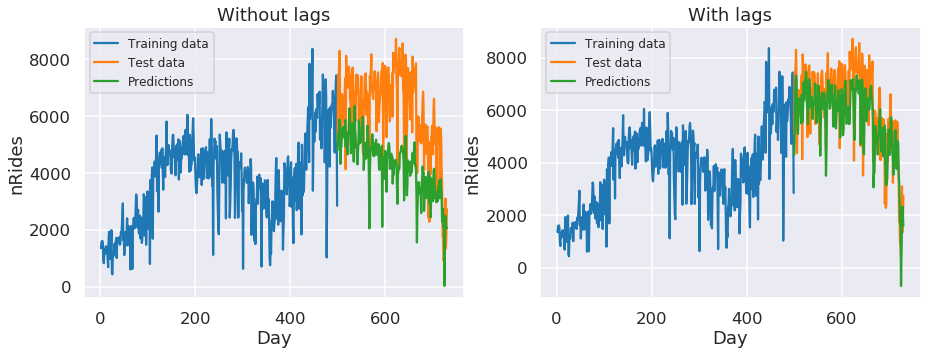

In [19]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(bikeTrain.index, bikeTrain['nRides'])
plt.plot(bikeTest.index, bikeTest['nRides'])
plt.plot(bikeTest.index, yPredTest)
plt.xlabel('Day');
plt.ylabel('nRides');
plt.title('Without lags');
plt.legend(labels=['Training data', 'Test data','Predictions'], loc = 'upper left', fontsize = 12);

plt.subplot(1,2,2)
plt.plot(bikeTrain.index, bikeTrain['nRides'])
plt.plot(bikeTest.index, bikeTest['nRides'])
plt.plot(bikeTest.index, yPredTestWithLags)
plt.xlabel('Day');
plt.ylabel('nRides');
plt.title('With lags');
plt.legend(labels=['Training data', 'Test data','Predictions'], loc = 'upper left', fontsize = 12);